# __*Generative Teaching Networks (GTNs)*__

A GTN, much like a GAN, is composed of 2 models: a Generator (i.e. Teacher), which produces synthetic data from noise, and Learner (i.e. Student), that trains on the synthetic data for some task. The key difference between a GAN and a GTN is that in a GAN, the 2 models work in an adversarial way, while in a GTN, the 2 models work cooperatively.

The main use of a GTN is to drastically reduce training times when we train multiple models. Alternatively, a GTN can also be used to find appropriate architechures for various problems. Also, a GTN can be trained on very training/validation little data.

The Generator used in the GTN is similar to a Conditional Generator used in the Condition GAN, which takes random noise as well as the class labels of the data for which it is trying to generate synthetic data.
The GTN implmented here also uses the following concepts: 

1. Meta-Learning: Meta-Learning refers to "learning to learn". These algorithms learn from the output of other Machine Learning algorithms. The Generator uses this concept 
2. Curriculum Learning: Training strategy that trains a Machine Learning model by providing data in a meaningful order. The noise used by the Generator is not random, it is learnt over time via backpropogation and is given in the same order to each Learner. This way the Generator uses noise that is most beneficial to the Learner to accelerate training. 
3. Neural Architecuture Search: USed to automate design of Deep Learning networks to achieve best possible performance with minimum amount of human supervision.


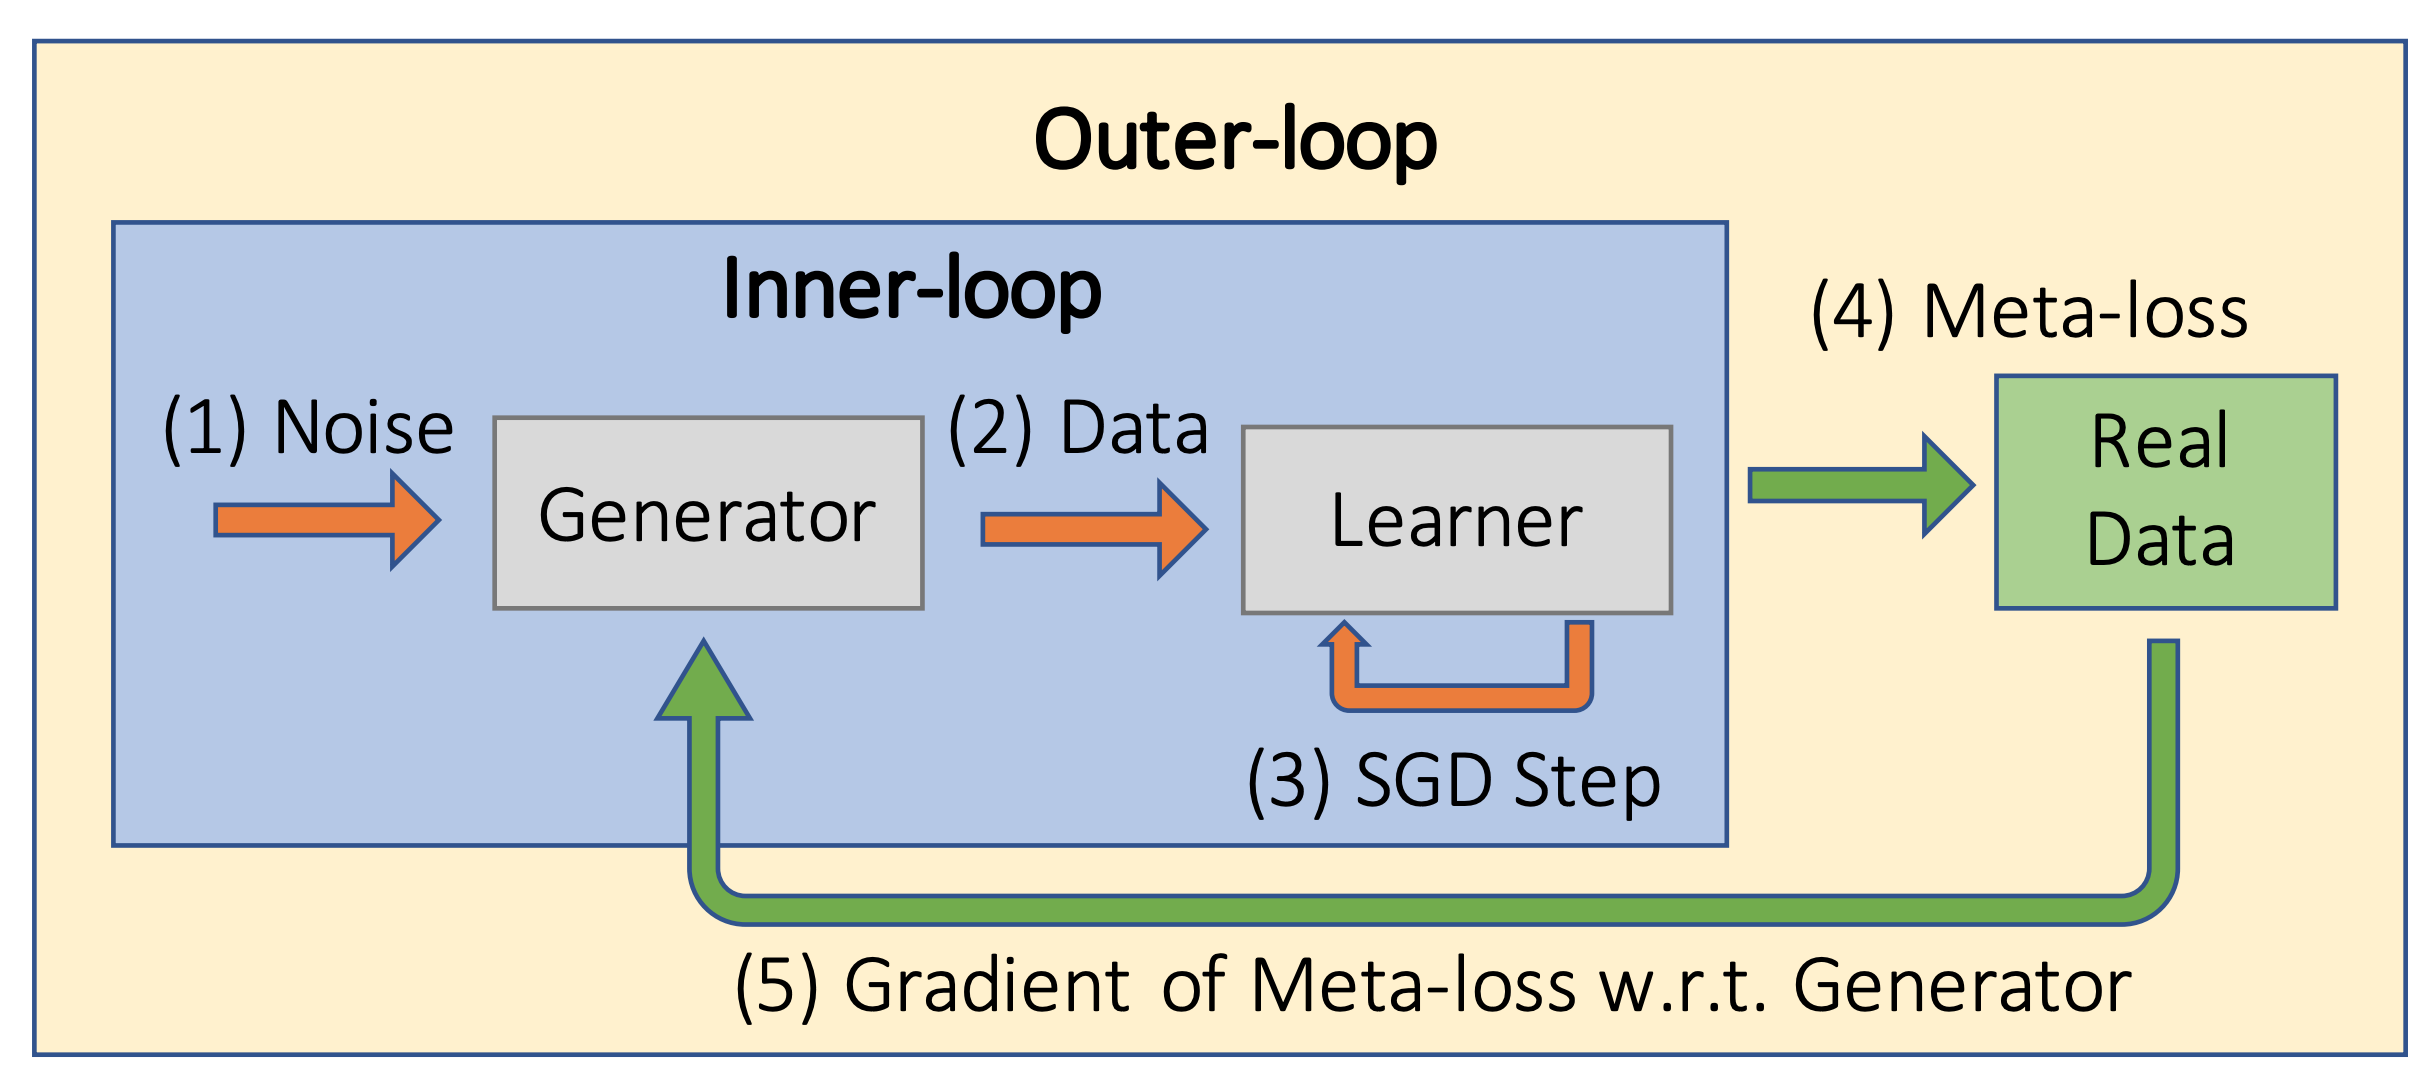

There are 2 loops, inner loop to train the Learner, and the outer loop that trains the Generator and optionally the noise. The Learner only learns on the synthetic data, and the Generator only learns on the real data.

1. The Generator takes the noise and the corresponding labels to generate synthetic data.
2. The Learner learnes on the synthetic data batches.
3. The Learner uses backpropogation to update it's parameters.
4. This trained Learner is finally given real data, loss (called Meta-Loss) is calculated. Gradients are calculated with respect to the Generators parameters and  then the Generator is updated.


For Meta-Loss, we use a library called Higher by Facebook AI Research which allows us to "unroll" inner higher gradients and hence supports higher order optimization. It turns torch.nn.Module instances "stateless" so that the changes made to the parameters can be tracked, and provides a suite of differential optimizers for Meta Learning.


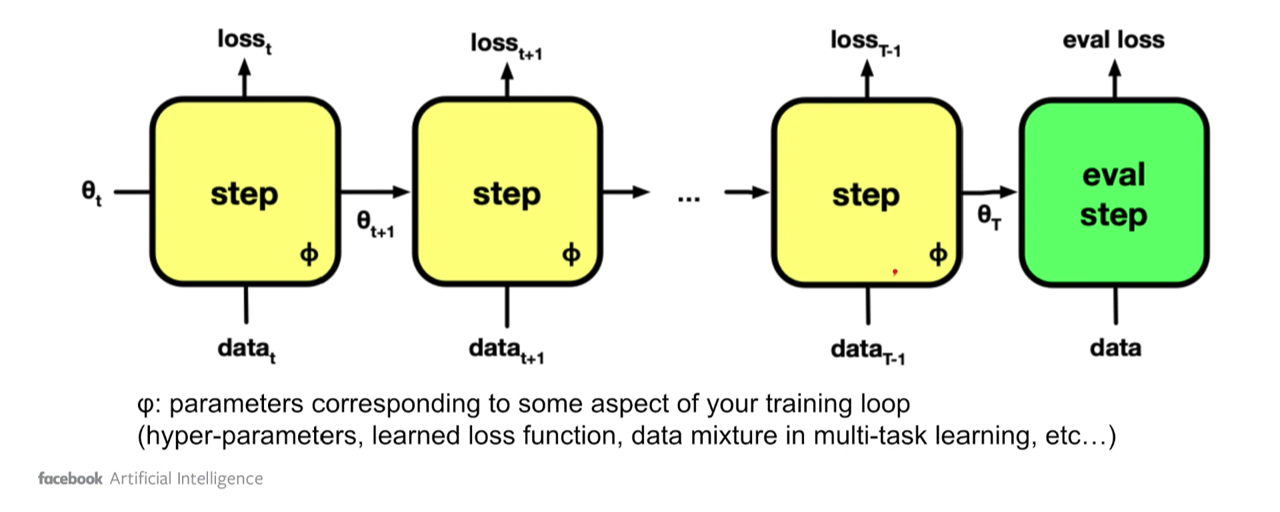

This diagram illustrates the training step that the Learner takes. The steps in yellow are the inner loop training steps using synthetic data. The data green used in the evaluation step. Backward pass starts at the evaluation loss and backpropogates through the various steps and to the indiviudal synthetic batches that the Generator generates. 


[Generative Teaching Networks: Accelerating Neural Architecture Search by Learning to Generate Synthetic Training Data (Such et al. 2019)](https://arxiv.org/abs/1912.07768)

# __*Importing Libraries*__


In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from koila import lazy
import higher

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'

import shutil
if os.path.exists('checkpoints'):
    shutil.rmtree('checkpoints')

# __*Parameters*__

In [2]:
from Models import Learner, Teacher1, Teacher2 
from utils import _cycle, _diffopt_state_dict, _imshow, _divide_chunks

In [3]:
# world_size = torch.cuda.device_count() ## Number of GPU's available

num_classes = 10                       ## Number of classes in the dataset
inner_loop_iterations = 32             ## Number of iterations in the inner training loop

batch_size = 256                       ## Number of images in a batch in the inner loop

# __*Importing Data*__


In [4]:
transform = transforms.Compose([
    transforms.Lambda(lambda x: np.array(x)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

# train = datasets.MNIST('./data', train=True, transform=transform, download=True)
# train, val = torch.utils.data.random_split(train, [50000, 10000])
# test = datasets.MNIST('./data', train=False, transform=transform, download=True)


train = datasets.CIFAR10('./data', train=True, transform=transform, download=True)
train, val = torch.utils.data.random_split(train, [inner_loop_iterations * batch_size, 50000 - inner_loop_iterations * batch_size]) # type: ignore
test = datasets.CIFAR10('./data', train=False, transform=transform, download=True)


train = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle=True, drop_last=True)
val = torch.utils.data.DataLoader(val, batch_size = batch_size * 2, shuffle=True, drop_last=True) # type: ignore
test = torch.utils.data.DataLoader(test, batch_size = batch_size * 2, shuffle=True, drop_last=True)

img_size = [3,32,32]


# train_loader = iter(_cycle(train))
# val_loader   = iter(_cycle(val))
# test_loader  = iter(_cycle(test)) 

mylearners = [Learner(img_size,
                     num_classes,
                      np.random.randint(low=32, high=256, size=(3,)),
                      np.random.randint(low=32, high=128, size=(1,)),)
              for i in range(100)]

LIM = len(mylearners)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
import importlib
import GTN
importlib.reload(GTN)


gtn = GTN.DataGTN(learnerlist = mylearners, num_classes= 10, 
               loss_fn = nn.CrossEntropyLoss(),
               device= device,
               batch_size=4
               )

In [6]:
gtn.compile(outer_opt=optim.Adam, 
    outer_opt_params={'lr':0.010},
    inner_opt=optim.Adam,
    inner_opt_params={'lr':0.01},
    override_params={'lr': 0.02},
    data=train
    )

In [7]:
gtn.train(val,test, epochs=1)

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# __*Initialization*__

In [32]:
# use_teacher = True
# use_curriculum = True 

# params_to_train = []

# if use_teacher == True:
    
#     noise_size = 128                       
#     teacher = Teacher1(128, img_size, 10).to(device)
# #     teacher = nn.DataParallel(teacher, device_ids=list(range(torch.cuda.device_count())))
    
#     params_to_train += list(teacher.parameters())
#     if use_curriculum ==True:
#         teacher_noise = nn.Parameter(torch.randn(inner_loop_iterations, batch_size, noise_size), requires_grad=True) 
#         params_to_train += [teacher_noise]
    
#     teacher_labels = torch.arange(batch_size) % num_classes                        ## Creating Labels for Generator
#     one_hot = nn.functional.one_hot(teacher_labels, num_classes)                                        ## One hot encoding above labels
        
# else: 
#     curriculum_data=[]
#     curriculum_labels = []

#     for i in range(inner_loop_iterations):
#         loader = next(train_loader)
#         curriculum_data  +=[loader[0]]
#         curriculum_labels+=[loader[1]]

#     curriculum_data = nn.Parameter(torch.stack((curriculum_data),0).detach(),requires_grad=True)
#     curriculum_labels = torch.stack(curriculum_labels,0).detach()
#     params_to_train += [curriculum_data]

# optimizer_input = {'lr': 0.02, 'momentum':0.9}
# # optimizer_input = {'lr': 0.02, 'betas': [0.9,0.99]}
# default_optimizer = optim.SGD

# optim_params = [nn.Parameter(Tensor(x).to(device)) if isinstance(x,list) else nn.Parameter(Tensor([x]).to(device))  for x in optimizer_input.values()]     
# # optim_params = nn.Parameter(Tensor(list(optimizer_input.values())).to(device), requires_grad=True)                          ## Parameters for SGD optimizer are also learnt 
# params_to_train += optim_params


# optimizer_teacher = optim.Adam(params_to_train,0.002, [0.9,0.9])                                                           ## Optimizer for Generator
# loss_fn = nn.CrossEntropyLoss()                                                                                ## Loss Fn used by the Learner

# # epochs = 1
# plot_steps = 25
# batch_exe = 4         

# batches = list(_divide_chunks(np.arange(inner_loop_iterations), batch_exe))

# path='./checkpoints'
# if not os.path.exists(path):
#     os.makedirs(path)

NameError: name 'img_size' is not defined

# __*GTN Training Loop*__

In [28]:
gtn = pd.DataFrame(columns= ('Path','Train Loss','Train Accuracy','Validation Loss','Validation Accuracy','Test Loss','Test Accuracy'))
# path='./checkpoints/gtn'
# if not os.path.exists(path):
#     os.makedirs(path)

# if use_teacher == True:
#     teacher.train()

# then = time.time()
# for it in range(LIM):
#     learner = deepcopy(mylearners[it]).to(device)
#     inner_optim = default_optimizer(learner.parameters(), lr=0.01, )
#     metrics={'Train Loss':[],'Train Accuracy':[],'Validation Loss':[],'Validation Accuracy':[],'Test Loss':[],'Test Accuracy':[]}

#     for epoch in range(epochs):
        
#         for batchsetid, batchset in enumerate(batches):
#             optimizer_teacher.zero_grad(set_to_none=True)
#             val_data, val_target = next(val_loader)
#             (val_data, val_target) = lazy(val_data, val_target, batch=0)
            
#             with higher.innerloop_ctx(learner, inner_optim, override = {key: [value] for key,value in zip(list(optimizer_input.keys()),optim_params)} ) as (flearner, diffopt):
                
#                 for step in batchset:
#                     if use_teacher == True:
#                         if use_curriculum == True:
#                             z_vec = teacher_noise[step]
#                         else:
#                             z_vec = torch.randn(batch_size, noise_size).to(device)
#                         train_data, train_target = teacher(z_vec.to(device), one_hot.to(device)), teacher_labels
#                     else:
#                         train_data, train_target = curriculum_data[step], curriculum_labels[step]

#                     train_data, train_target= train_data.to(device), train_target.to(device)
#                     train_output = flearner(train_data)
#                     train_loss = loss_fn(train_output, train_target) 
#                     train_pred = train_output.argmax(dim=1, keepdim=True) 
#                     train_accuracy = np.round(train_pred.eq(train_target.view_as(train_pred)).sum().item() / len(train_target) * 100, 2)
#                     diffopt.step(train_loss)
            
#                 val_data, val_target= val_data.to(device), val_target.to(device)
#                 val_output = flearner(val_data)
#                 val_loss = loss_fn(val_output, val_target)
#                 val_pred = val_output.argmax(dim=1, keepdim=True)
#                 val_accuracy = np.round(val_pred.eq(val_target.view_as(val_pred)).sum().item() / len(val_target) * 100, 2)
#                 val_loss.backward()
#                 optimizer_teacher.step()

#                 learner.load_state_dict(flearner.state_dict())
#                 inner_optim.load_state_dict(_diffopt_state_dict(diffopt))
                
#         with torch.no_grad():
#             learner.eval()
#             test_data, test_target = next(test_loader)
#             (test_data, test_target) = lazy(test_data, test_target, batch=0)
#             test_data, test_target= test_data.to(device), test_target.to(device)

#             test_output = learner(test_data) 
#             test_loss = loss_fn(test_output, test_target)
#             test_pred = test_output.argmax(dim=1, keepdim=True)
#             test_accuracy = np.round(test_pred.eq(test_target.view_as(test_pred)).sum().item() / len(test_target) * 100 ,2)

#             metrics["Train Accuracy"].append(train_accuracy)
#             metrics["Train Loss"].append(np.round(train_loss.item(),3))
#             metrics["Validation Accuracy"].append(val_accuracy)
#             metrics["Validation Loss"].append(np.round(val_loss.item(),3))
#             metrics["Test Accuracy"].append(test_accuracy)
#             metrics["Test Loss"].append(np.round(test_loss.item(),3))

#     print("E:",it//steps_per_epoch, 
#                   "\tB:",it%steps_per_epoch, 
#                   "\t Train Acc: %5.2f" % train_accuracy, "%",
#                   "  Loss: %.3f" % np.round(train_loss.item(),3),
#                   " \t Val Acc: %5.2f" % val_accuracy, "%",
#                   "  Loss: %.3f" % np.round(val_loss.item(),3), 
#                   "   \t Test Acc: %5.2f" % test_accuracy, "%",
#                   "  Loss: %.3f" % np.round(test_loss.item(),3), 
#                   "  \tIT: ",(it+1),
#                   sep=""
#                  )
            
            
#     inner_optim.zero_grad()
#     checkpoint = { 'model': learner, 'optimizer': inner_optim.state_dict() }
#     metrics["Path"] = f'{path}/{it}.pth'
#     torch.save(checkpoint, metrics['Path'])
#     gtn.loc[it] = metrics
#     if (it + 1) % plot_steps == 0:
#         _imshow(train_data)    


# del train_loss, val_loss, test_loss, train_data, val_data, test_data, learner, inner_optim
# gc.collect()
# torch.cuda.empty_cache()


# now = time.time()
# # curriculum_data.requires_grads=False

# print("\n\nTotal Time Taken: ",now-then, "\t Average Time: ", (now-then)/LIM)

ValueError: optimizer got an empty parameter list

In [ ]:
# if use_teacher == True:
#     curriculum_data=[]
#     curriculum_labels=[]
#     with torch.no_grad():
#         for step in range(inner_loop_iterations):
#             curriculum_data += [teacher(teacher_noise[step].to(device),one_hot.to(device)).detach()]
#             curriculum_labels += [teacher_labels]
#             curriculum_data[step].requires_grads = False
#             _imshow(curriculum_data[step])
            
#         curriculum_data = nn.Parameter(torch.stack((curriculum_data),0).detach(),requires_grad=False)

# __*Normal Curriculum*__

In [ ]:
# mylearners = [Learner(np.random.randint(low=32, high=256, size=(3,)),
#                       np.random.randint(low=32, high=128, size=(1,)))
#               for i in range(LIM)]

In [ ]:
# train_loader = iter(_cycle(train))
# val_loader   = iter(_cycle(val))
# test_loader  = iter(_cycle(test)) 




# normalcurriculum = pd.DataFrame(columns= ('Path','Train Loss','Train Accuracy','Validation Loss','Validation Accuracy','Test Loss','Test Accuracy'))
# path='./checkpoints/normalcurriculum'
# if not os.path.exists(path):
#     os.makedirs(path)

# train_target = Tensor([x % num_classes for x in range(batch_size)]).to(device)      ## Creating Labels for Generator

# then = time.time()
# for it in range(LIM):
#     learner = deepcopy(mylearners[it]).to(device)
#     inner_optim = optim.SGD(learner.parameters(), **{key: value.item() for key,value in zip(list(optimizer_input.keys()),optim_params)})
#     metrics={'Train Loss':[],'Train Accuracy':[],'Validation Loss':[],'Validation Accuracy':[],'Test Loss':[],'Test Accuracy':[]}

#     for epoch in range(epochs):        
#         for batchset in batches:
#             for step in batchset:
#                 learner.train()
#                 inner_optim.zero_grad()
#                 if use_teacher == True:
#                     train_data, train_target = curriculum_data[step], train_target
#                 else:
#                     train_data, train_target = curriculum_data[step], curriculum_labels[step]
                    
#                 train_data, train_target= train_data.to(device, non_blocking=True), train_target.to(device, non_blocking=True)
#                 train_output = learner(train_data)
#                 train_loss = loss_fn(train_output, train_target) 
#                 train_pred = train_output.argmax(dim=1, keepdim=True) 
#                 train_accuracy = np.round(train_pred.eq(train_target.view_as(train_pred)).sum().item() / batch_size * 100, 2)
#                 train_loss.backward()
#                 inner_optim.step()
                    
#         with torch.no_grad():    
#             learner.eval()
#             val_data, val_target = next(val_loader)
#             (val_data, val_target) = lazy(val_data, val_target, batch=0)
#             val_data, val_target= val_data.to(device), val_target.to(device)
#             val_output = learner(val_data)
#             val_loss = loss_fn(val_output, val_target)
#             val_pred = val_output.argmax(dim=1, keepdim=True)
#             val_accuracy = np.round(val_pred.eq(val_target.view_as(val_pred)).sum().item() / (2 * batch_size) * 100, 2)
        
#             test_data, test_target = next(test_loader)
#             (test_data, test_target) = lazy(test_data, test_target, batch=0)
#             test_data, test_target= test_data.to(device), test_target.to(device)
#             test_output = learner(test_data)
#             test_loss = loss_fn(test_output, test_target)
#             test_pred = test_output.argmax(dim=1, keepdim=True)
#             test_accuracy = np.round(test_pred.eq(test_target.view_as(test_pred)).sum().item() / (2 * batch_size) * 100 ,2)

#             metrics["Train Accuracy"].append(train_accuracy)
#             metrics["Train Loss"].append(np.round(train_loss.item(),3))
#             metrics["Validation Accuracy"].append(val_accuracy)
#             metrics["Validation Loss"].append(np.round(val_loss.item(),3))
#             metrics["Test Accuracy"].append(test_accuracy)
#             metrics["Test Loss"].append(np.round(test_loss.item(),3))
            
#     print("E:",it//steps_per_epoch, 
#                   "\tB:",it%steps_per_epoch, 
#                   "\t Train Acc: %5.2f" % train_accuracy, "%",
#                   "  Loss: %.3f" % np.round(train_loss.item(),3),
#                   " \t Val Acc: %5.2f" % val_accuracy, "%",
#                   "  Loss: %.3f" % np.round(val_loss.item(),3), 
#                   "   \t Test Acc: %5.2f" % test_accuracy, "%",
#                   "  Loss: %.3f" % np.round(test_loss.item(),3), 
#                   "  \tIT: ",(it+1),
#                   sep=""
#                  )
    
#     inner_optim.zero_grad()
#     checkpoint = { 'model': learner.state_dict(), 'optimizer': inner_optim.state_dict() }
#     metrics["Path"] = f'{path}/{it}.pth'
#     torch.save(checkpoint, metrics['Path'])
#     normalcurriculum.loc[it] = metrics

#     if (it + 1) % plot_steps == 0:
#         _imshow(train_data) 
    
#     del train_loss, val_loss, test_loss, train_data, val_data, test_data, learner, inner_optim
#     gc.collect()
#     torch.cuda.empty_cache()
    
# now = time.time()

# print("\n\nTotal Time Taken: ",now-then, "\t Average Time: ", (now-then)/LIM)

# __*Normal Dataset*__

E:0	B:0	 Train Acc: 48.05%  Loss: 1.519 	 Val Acc: 49.41%  Loss: 1.449   	 Test Acc: 48.44%  Loss: 1.502  	IT: 1
E:0	B:1	 Train Acc: 43.36%  Loss: 1.580 	 Val Acc: 44.34%  Loss: 1.564   	 Test Acc: 40.82%  Loss: 1.627  	IT: 2
E:0	B:2	 Train Acc: 46.48%  Loss: 1.516 	 Val Acc: 46.48%  Loss: 1.493   	 Test Acc: 48.24%  Loss: 1.449  	IT: 3
E:0	B:3	 Train Acc: 37.50%  Loss: 1.549 	 Val Acc: 44.14%  Loss: 1.483   	 Test Acc: 44.92%  Loss: 1.535  	IT: 4
E:0	B:4	 Train Acc: 42.58%  Loss: 1.619 	 Val Acc: 44.14%  Loss: 1.495   	 Test Acc: 45.12%  Loss: 1.476  	IT: 5
E:0	B:5	 Train Acc: 46.09%  Loss: 1.458 	 Val Acc: 44.73%  Loss: 1.535   	 Test Acc: 47.46%  Loss: 1.435  	IT: 6
E:0	B:6	 Train Acc: 46.48%  Loss: 1.453 	 Val Acc: 46.88%  Loss: 1.469   	 Test Acc: 49.61%  Loss: 1.344  	IT: 7
E:0	B:7	 Train Acc: 40.23%  Loss: 1.548 	 Val Acc: 45.70%  Loss: 1.546   	 Test Acc: 44.92%  Loss: 1.502  	IT: 8
E:0	B:8	 Train Acc: 44.53%  Loss: 1.554 	 Val Acc: 48.44%  Loss: 1.438   	 Test Acc: 47.66%  Los

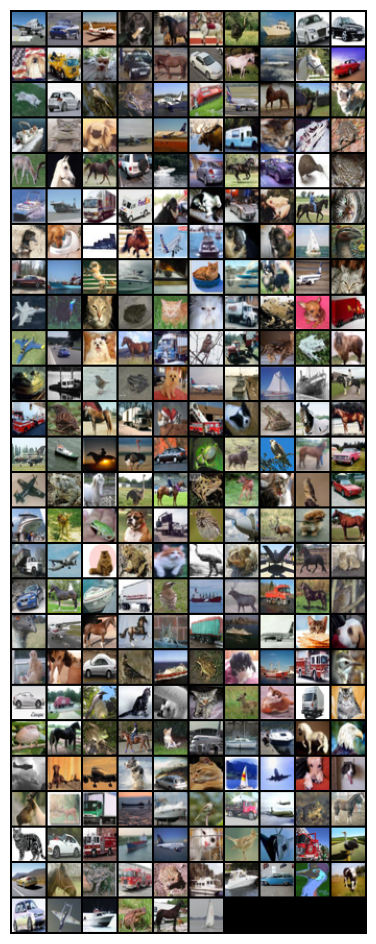

E:0	B:25	 Train Acc: 50.39%  Loss: 1.451 	 Val Acc: 42.77%  Loss: 1.520   	 Test Acc: 47.27%  Loss: 1.453  	IT: 26
E:0	B:26	 Train Acc: 51.17%  Loss: 1.438 	 Val Acc: 46.88%  Loss: 1.492   	 Test Acc: 47.07%  Loss: 1.455  	IT: 27
E:0	B:27	 Train Acc: 42.19%  Loss: 1.556 	 Val Acc: 44.73%  Loss: 1.495   	 Test Acc: 42.38%  Loss: 1.552  	IT: 28
E:0	B:28	 Train Acc: 41.02%  Loss: 1.508 	 Val Acc: 43.55%  Loss: 1.497   	 Test Acc: 44.14%  Loss: 1.531  	IT: 29
E:0	B:29	 Train Acc: 46.88%  Loss: 1.505 	 Val Acc: 46.29%  Loss: 1.432   	 Test Acc: 47.27%  Loss: 1.434  	IT: 30
E:0	B:30	 Train Acc: 44.14%  Loss: 1.579 	 Val Acc: 50.59%  Loss: 1.473   	 Test Acc: 46.48%  Loss: 1.460  	IT: 31
E:0	B:31	 Train Acc: 48.83%  Loss: 1.375 	 Val Acc: 47.46%  Loss: 1.405   	 Test Acc: 47.27%  Loss: 1.402  	IT: 32
E:0	B:32	 Train Acc: 46.09%  Loss: 1.517 	 Val Acc: 42.19%  Loss: 1.523   	 Test Acc: 44.73%  Loss: 1.552  	IT: 33
E:0	B:33	 Train Acc: 43.36%  Loss: 1.539 	 Val Acc: 41.99%  Loss: 1.615   	 Test

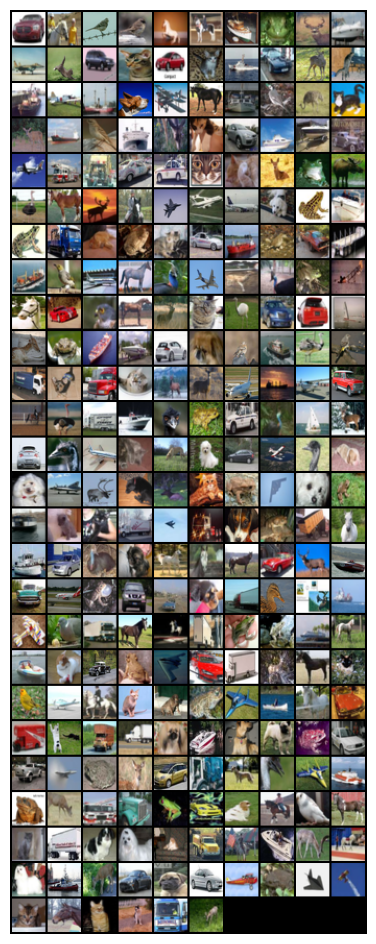

E:0	B:50	 Train Acc: 48.05%  Loss: 1.502 	 Val Acc: 46.48%  Loss: 1.461   	 Test Acc: 48.24%  Loss: 1.469  	IT: 51
E:0	B:51	 Train Acc: 50.00%  Loss: 1.435 	 Val Acc: 52.73%  Loss: 1.277   	 Test Acc: 49.61%  Loss: 1.386  	IT: 52
E:0	B:52	 Train Acc: 43.75%  Loss: 1.535 	 Val Acc: 48.44%  Loss: 1.465   	 Test Acc: 48.24%  Loss: 1.427  	IT: 53
E:0	B:53	 Train Acc: 42.19%  Loss: 1.573 	 Val Acc: 44.34%  Loss: 1.541   	 Test Acc: 42.38%  Loss: 1.595  	IT: 54
E:0	B:54	 Train Acc: 41.80%  Loss: 1.619 	 Val Acc: 42.58%  Loss: 1.570   	 Test Acc: 49.22%  Loss: 1.468  	IT: 55
E:0	B:55	 Train Acc: 51.95%  Loss: 1.349 	 Val Acc: 46.48%  Loss: 1.445   	 Test Acc: 46.88%  Loss: 1.416  	IT: 56
E:0	B:56	 Train Acc: 44.92%  Loss: 1.532 	 Val Acc: 47.85%  Loss: 1.504   	 Test Acc: 45.70%  Loss: 1.515  	IT: 57
E:0	B:57	 Train Acc: 42.19%  Loss: 1.465 	 Val Acc: 43.36%  Loss: 1.488   	 Test Acc: 48.24%  Loss: 1.450  	IT: 58
E:0	B:58	 Train Acc: 46.09%  Loss: 1.440 	 Val Acc: 44.92%  Loss: 1.526   	 Test

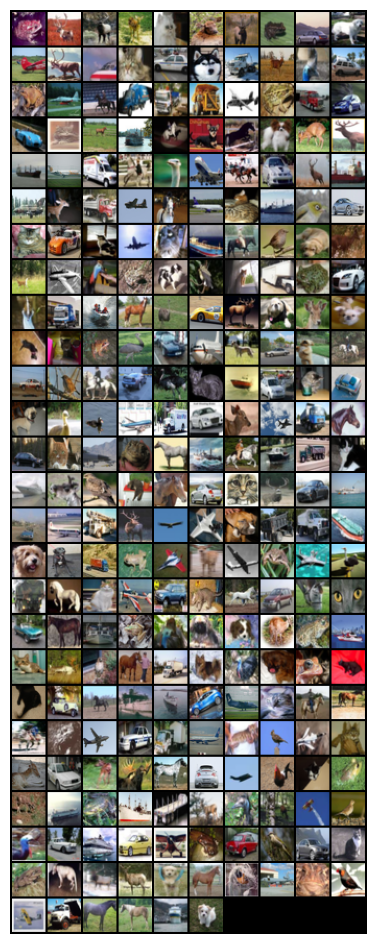

E:0	B:75	 Train Acc: 44.53%  Loss: 1.520 	 Val Acc: 45.90%  Loss: 1.531   	 Test Acc: 43.75%  Loss: 1.545  	IT: 76
E:0	B:76	 Train Acc: 46.09%  Loss: 1.537 	 Val Acc: 48.05%  Loss: 1.455   	 Test Acc: 46.68%  Loss: 1.511  	IT: 77
E:0	B:77	 Train Acc: 56.25%  Loss: 1.323 	 Val Acc: 49.80%  Loss: 1.340   	 Test Acc: 47.46%  Loss: 1.393  	IT: 78
E:0	B:78	 Train Acc: 39.06%  Loss: 1.541 	 Val Acc: 41.02%  Loss: 1.581   	 Test Acc: 45.51%  Loss: 1.471  	IT: 79
E:0	B:79	 Train Acc: 46.88%  Loss: 1.469 	 Val Acc: 42.19%  Loss: 1.528   	 Test Acc: 44.92%  Loss: 1.530  	IT: 80
E:0	B:80	 Train Acc: 42.19%  Loss: 1.539 	 Val Acc: 42.97%  Loss: 1.544   	 Test Acc: 41.41%  Loss: 1.542  	IT: 81
E:1	B:0	 Train Acc: 38.67%  Loss: 1.614 	 Val Acc: 47.07%  Loss: 1.473   	 Test Acc: 47.66%  Loss: 1.412  	IT: 82
E:1	B:1	 Train Acc: 50.78%  Loss: 1.481 	 Val Acc: 47.46%  Loss: 1.457   	 Test Acc: 40.82%  Loss: 1.562  	IT: 83
E:1	B:2	 Train Acc: 46.48%  Loss: 1.467 	 Val Acc: 43.36%  Loss: 1.497   	 Test Ac

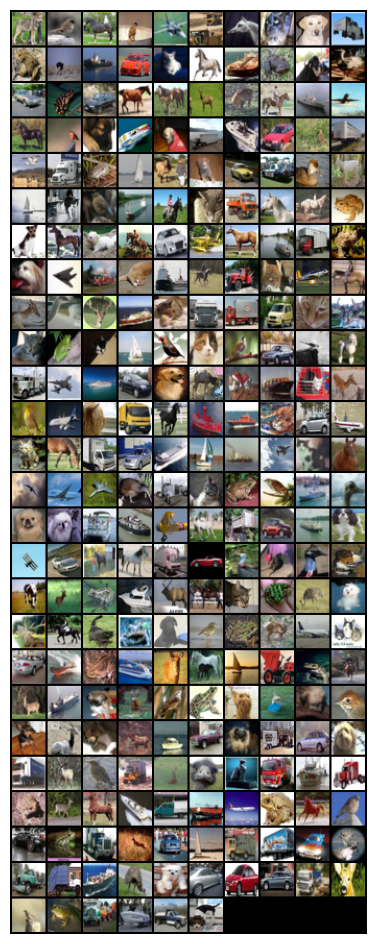



Total Time Taken:  308.4185037612915 	 Average Time:  3.084185037612915


In [ ]:
# val_loader   = iter(_cycle(val))
# test_loader  = iter(_cycle(test)) 


# normaldataset = pd.DataFrame(columns= ('Path','Train Loss','Train Accuracy','Validation Loss','Validation Accuracy','Test Loss','Test Accuracy'))
# path='./checkpoints/normaldataset'
# if not os.path.exists(path):
#     os.makedirs(path)

# then = time.time()
# for it in range(LIM):
#     learner = deepcopy(mylearners[it]).to(device)
#     inner_optim = optim.Adam(learner.parameters(), lr=0.01)
#     metrics={'Train Loss':[],'Train Accuracy':[],'Validation Loss':[],'Validation Accuracy':[],'Test Loss':[],'Test Accuracy':[]}

#     for epoch in range(epochs):        
#         train_loader = iter(_cycle(train))
#         for batchset in batches:
#             for step in batchset:
#                 learner.train()
#                 inner_optim.zero_grad()
#                 train_data, train_target = next(train_loader)

#                 train_data, train_target= train_data.to(device, non_blocking=True), train_target.to(device, non_blocking=True)
#                 train_output = learner(train_data)
#                 train_loss = loss_fn(train_output, train_target) 
#                 train_pred = train_output.argmax(dim=1, keepdim=True) 
#                 train_accuracy = np.round(train_pred.eq(train_target.view_as(train_pred)).sum().item() / batch_size * 100, 2)
#                 train_loss.backward()
#                 inner_optim.step()
                    
#         with torch.no_grad():    
#             learner.eval()
#             val_data, val_target = next(val_loader)
#             (val_data, val_target) = lazy(val_data, val_target, batch=0)
#             val_data, val_target= val_data.to(device), val_target.to(device)
#             val_output = learner(val_data)
#             val_loss = loss_fn(val_output, val_target)
#             val_pred = val_output.argmax(dim=1, keepdim=True)
#             val_accuracy = np.round(val_pred.eq(val_target.view_as(val_pred)).sum().item() / (2 * batch_size) * 100, 2)
        
#             test_data, test_target = next(test_loader)
#             (test_data, test_target) = lazy(test_data, test_target, batch=0)
#             test_data, test_target= test_data.to(device), test_target.to(device)
#             test_output = learner(test_data)
#             test_loss = loss_fn(test_output, test_target)
#             test_pred = test_output.argmax(dim=1, keepdim=True)
#             test_accuracy = np.round(test_pred.eq(test_target.view_as(test_pred)).sum().item() / (2 * batch_size) * 100 ,2)

#             metrics["Train Accuracy"].append(train_accuracy)
#             metrics["Train Loss"].append(np.round(train_loss.item(),3))
#             metrics["Validation Accuracy"].append(val_accuracy)
#             metrics["Validation Loss"].append(np.round(val_loss.item(),3))
#             metrics["Test Accuracy"].append(test_accuracy)
#             metrics["Test Loss"].append(np.round(test_loss.item(),3))
            
#     print("E:",it//steps_per_epoch, 
#                   "\tB:",it%steps_per_epoch, 
#                   "\t Train Acc: %5.2f" % train_accuracy, "%",
#                   "  Loss: %.3f" % np.round(train_loss.item(),3),
#                   " \t Val Acc: %5.2f" % val_accuracy, "%",
#                   "  Loss: %.3f" % np.round(val_loss.item(),3), 
#                   "   \t Test Acc: %5.2f" % test_accuracy, "%",
#                   "  Loss: %.3f" % np.round(test_loss.item(),3), 
#                   "  \tIT: ",(it+1),
#                   sep=""
#                  )
                    
#     inner_optim.zero_grad()
#     checkpoint = { 'model': learner.state_dict(), 'optimizer': inner_optim.state_dict() }
#     metrics["Path"] = f'{path}/{it}.pth'
#     torch.save(checkpoint, metrics['Path'])
#     normaldataset.loc[it] = metrics

#     if (it + 1) % plot_steps == 0:
#         _imshow(train_data) 
    
#     del train_loss, val_loss, test_loss, train_data, val_data, test_data, learner, inner_optim
#     gc.collect()
#     torch.cuda.empty_cache()
    
# now = time.time()

# print("\n\nTotal Time Taken: ",now-then, "\t Average Time: ", (now-then)/LIM)

# __*Results*__

In [ ]:
# plt.style.use('ggplot')
# plt.rcParams["figure.figsize"] = (16,4)


# plt.subplot(1,2,1)
# plt.plot(range(LIM),gtn["Train Loss"].apply(lambda x:x[-1]),              label="GTN",              linewidth=0.75, color="black")
# plt.plot(range(LIM),normaldataset["Train Loss"].apply(lambda x:x[-1]),    label="Normal Dataset",   linewidth=0.75, color="red")
# plt.plot(range(LIM),normalcurriculum["Train Loss"].apply(lambda x:x[-1]), label="Normal Curriculum",linewidth=0.75, color="green")
# # plt.plot(range(LIM),gtncurriculum["Train Loss"].apply(lambda x:x[-1]),    label="GTN Curriculum",   linewidth=0.75, color="blue")
# # plt.plot(range(LIM),gtndataset["Train Loss"].apply(lambda x:x[-1]),       label="GTN Dataset",      linewidth=0.75, color="gray")
# plt.title("Train Loss")
# plt.legend()
# plt.subplot(1,2,2)
# plt.plot(range(LIM),gtn["Train Accuracy"].apply(lambda x:x[-1]),              label= "GTN",             linewidth=0.75, color= "black")
# plt.plot(range(LIM),normaldataset["Train Accuracy"].apply(lambda x:x[-1]),    label="Normal Dataset",   linewidth=0.75, color= "red")
# plt.plot(range(LIM),normalcurriculum["Train Accuracy"].apply(lambda x:x[-1]), label="Normal Curriculum",linewidth=0.75, color= "green")
# # plt.plot(range(LIM),gtncurriculum["Train Accuracy"].apply(lambda x:x[-1]),    label="GTN Curriculum",   linewidth=0.75, color= "blue")
# # plt.plot(range(LIM),gtndataset["Train Accuracy"].apply(lambda x:x[-1]),       label="GTN Dataset",      linewidth=0.75, color= "gray")

# plt.title("Train Accuracy")
# plt.legend()
# plt.show()

# plt.subplot(1,2,1)
# plt.plot(range(LIM),gtn["Validation Loss"].apply(lambda x:x[-1]),              label="GTN",              linewidth=0.75, color="black")
# plt.plot(range(LIM),normaldataset["Validation Loss"].apply(lambda x:x[-1]),    label="Normal Dataset",   linewidth=0.75, color="red")
# plt.plot(range(LIM),normalcurriculum["Validation Loss"].apply(lambda x:x[-1]), label="Normal Curriculum",linewidth=0.75, color="green")
# # plt.plot(range(LIM),gtncurriculum["Validation Loss"].apply(lambda x:x[-1]),    label="GTN Curriculum",   linewidth=0.75, color="blue")
# # plt.plot(range(LIM),gtndataset["Validation Loss"].apply(lambda x:x[-1]),       label="GTN Dataset",      linewidth=0.75, color="gray")
# plt.title("Validation Loss")
# plt.legend()
# plt.subplot(1,2,2)
# plt.plot(range(LIM),gtn["Validation Accuracy"].apply(lambda x:x[-1]),              label= "GTN",             linewidth=0.75, color= "black")
# plt.plot(range(LIM),normaldataset["Validation Accuracy"].apply(lambda x:x[-1]),    label="Normal Dataset",   linewidth=0.75, color= "red")
# plt.plot(range(LIM),normalcurriculum["Validation Accuracy"].apply(lambda x:x[-1]), label="Normal Curriculum",linewidth=0.75, color= "green")
# # plt.plot(range(LIM),gtncurriculum["Validation Accuracy"].apply(lambda x:x[-1]),    label="GTN Curriculum",   linewidth=0.75, color= "blue")
# # plt.plot(range(LIM),gtndataset["Validation Accuracy"].apply(lambda x:x[-1]),       label="GTN Dataset",      linewidth=0.75, color= "gray")
# plt.title("Validation Accuracy")
# plt.legend()
# plt.show()

# plt.subplot(1,2,1)
# plt.plot(range(LIM),gtn["Test Loss"].apply(lambda x:x[-1]),              label="GTN",              linewidth=0.75, color="black")
# plt.plot(range(LIM),normaldataset["Test Loss"].apply(lambda x:x[-1]),    label="Normal Dataset",   linewidth=0.75, color="red")
# plt.plot(range(LIM),normalcurriculum["Test Loss"].apply(lambda x:x[-1]), label="Normal Curriculum",linewidth=0.75, color="green")
# # plt.plot(range(LIM),gtncurriculum["Test Loss"].apply(lambda x:x[-1]),    label="GTN Curriculum",   linewidth=0.75, color="blue")
# # plt.plot(range(LIM),gtndataset["Test Loss"].apply(lambda x:x[-1]),       label="GTN Dataset",      linewidth=0.75, color="gray")
# plt.title("Test Loss")
# plt.legend()
# plt.subplot(1,2,2)
# plt.plot(range(LIM),gtn["Test Accuracy"].apply(lambda x:x[-1]),              label= "GTN",             linewidth=0.75, color= "black")
# plt.plot(range(LIM),normaldataset["Test Accuracy"].apply(lambda x:x[-1]),    label="Normal Dataset",   linewidth=0.75, color= "red")
# plt.plot(range(LIM),normalcurriculum["Test Accuracy"].apply(lambda x:x[-1]), label="Normal Curriculum",linewidth=0.75, color= "green")
# # plt.plot(range(LIM),gtncurriculum["Test Accuracy"].apply(lambda x:x[-1]),    label="GTN Curriculum",   linewidth=0.75, color= "blue")
# # plt.plot(range(LIM),gtndataset["Test Accuracy"].apply(lambda x:x[-1]),       label="GTN Dataset",      linewidth=0.75, color= "gray")
# plt.title("Test Accuracy")
# plt.legend()
# plt.show()

# # plt.tight_layout()
